In [88]:
# ─── 1. INSTALL & IMPORTS ────────────────────────────────────────────────────
import os, glob, random, warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import rasterio
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

warnings.filterwarnings('ignore')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [89]:
# ─── 2. PATHS ────────────────────────────────────────────────────────────────
BASE    = Path('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026')
TRAIN   = BASE / 'train'
VAL     = BASE / 'val'
RESULT  = BASE / 'result.csv'

CLASSES   = ['Health', 'Rust', 'Other']
CLS2IDX   = {c: i for i, c in enumerate(CLASSES)}
IDX2CLS   = {i: c for c, i in CLS2IDX.items()}

# HS band config — drop first 10 and last 14 noisy bands → keep 101 clean bands
HS_TOTAL   = 125
HS_START   = 10
HS_END     = HS_TOTAL - 14   # = 111
HS_CLEAN   = HS_END - HS_START  # = 101
PCA_COMPS  = 30

IMG_SIZE   = 64   # resize all spatial dims to this
BATCH_SIZE = 32
EPOCHS     = 40
N_FOLDS    = 5
LR         = 3e-4

In [90]:
import os

base = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026'

for root, dirs, files in os.walk(base):
    depth = root.replace(base, '').count(os.sep)
    indent = '  ' * depth
    print(f'{indent}{os.path.basename(root)}/')
    for f in sorted(files)[:3]:
        print(f'{indent}  {f}')
    if len(files) > 3:
        print(f'{indent}  ... ({len(files)} files total)')


beyond-visible-spectrum-ai-for-agriculture-2026/
  Kaggle_Prepared/
    val/
      HS/
        val_000a83c1.tif
        val_00a704b1.tif
        val_01dde030.tif
        ... (300 files total)
      RGB/
        val_000a83c1.png
        val_00a704b1.png
        val_01dde030.png
        ... (300 files total)
      MS/
        val_000a83c1.tif
        val_00a704b1.tif
        val_01dde030.tif
        ... (300 files total)
    train/
      HS/
        Health_hyper_1.tif
        Health_hyper_10.tif
        Health_hyper_100.tif
        ... (600 files total)
      RGB/
        Health_hyper_1.png
        Health_hyper_10.png
        Health_hyper_100.png
        ... (600 files total)
      MS/
        Health_hyper_1.tif
        Health_hyper_10.tif
        Health_hyper_100.tif
        ... (600 files total)


In [91]:
# ─── 3. DATA LOADING UTILITIES ───────────────────────────────────────────────

def load_tif(path, bands=None):
    """Load a GeoTIFF, return (H, W, C) numpy float32."""
    with rasterio.open(path) as src:
        data = src.read()  # (C, H, W)
    data = data.astype(np.float32)
    if bands is not None:
        data = data[bands]
    return np.transpose(data, (1, 2, 0))  # (H, W, C)

def load_rgb(path):
    """Load PNG RGB image, return (H, W, 3) float32 [0,1]."""
    img = np.array(Image.open(path).convert('RGB')).astype(np.float32) / 255.0
    return img

def load_hs_clean(path):
    """Load HS, strip noisy bands, return (H,W,101)."""
    return load_tif(path, bands=list(range(HS_START, HS_END)))

def load_ms(path):
    """Load MS 5-band, return (H,W,5)."""
    return load_tif(path)

def normalize_per_band(arr):
    """Per-band standardization. arr: (H,W,C)"""
    out = arr.copy()
    for c in range(arr.shape[2]):
        band = arr[:, :, c]
        mu, sigma = band.mean(), band.std() + 1e-8
        out[:, :, c] = (band - mu) / sigma
    return out

def resize_hwc(arr, size):
    """Resize (H,W,C) → (size,size,C) using PIL per-band."""
    H, W, C = arr.shape
    out = np.zeros((size, size, C), dtype=np.float32)
    for c in range(C):
        band = arr[:, :, c]
        # scale to 0-255 for PIL resize then back
        mn, mx = band.min(), band.max()
        if mx - mn < 1e-8:
            continue
        band_u8 = ((band - mn) / (mx - mn) * 255).astype(np.uint8)
        pil_img = Image.fromarray(band_u8).resize((size, size), Image.BILINEAR)
        out[:, :, c] = (np.array(pil_img).astype(np.float32) / 255.0) * (mx - mn) + mn
    return out

In [92]:
# ─── 4. BUILD TRAINING FILE LIST (fixed for actual folder structure) ──────────

BASE  = Path('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026/Kaggle_Prepared')
TRAIN = BASE / 'train'
VAL   = BASE / 'val'

def get_label_from_stem(stem):
    """Extract class from filename e.g. Health_hyper_1 → Health"""
    stem_lower = stem.lower()
    if stem_lower.startswith('health'):
        return CLS2IDX['Health']
    elif stem_lower.startswith('rust'):
        return CLS2IDX['Rust']
    elif stem_lower.startswith('other'):
        return CLS2IDX['Other']
    else:
        return None

train_records = []
hs_files = sorted(glob.glob(str(TRAIN / 'HS' / '*.tif')))

for hs_path in hs_files:
    stem  = Path(hs_path).stem
    label = get_label_from_stem(stem)
    if label is None:
        print(f'  WARNING: could not parse label from {stem}')
        continue
    ms_path  = str(TRAIN / 'MS'  / (stem + '.tif'))
    rgb_path = str(TRAIN / 'RGB' / (stem + '.png'))
    if Path(ms_path).exists() and Path(rgb_path).exists():
        train_records.append({'stem': stem, 'hs': hs_path,
                              'ms': ms_path, 'rgb': rgb_path,
                              'label': label})

train_df = pd.DataFrame(train_records)
print(f'Total training samples: {len(train_df)}')
print(train_df['label'].value_counts().rename(IDX2CLS))

Total training samples: 600
label
Health    200
Other     200
Rust      200
Name: count, dtype: int64


In [93]:
# ─── 5. FIT PCA ON TRAINING HS DATA ─────────────────────────────────────────
# Sample all training HS pixels to fit PCA
print('Fitting PCA on HS training data (this may take ~1 min)...')

pixel_sample = []
for _, row in train_df.iterrows():
    hs = load_hs_clean(row['hs'])          # (H, W, 101)
    H, W, _ = hs.shape
    flat = hs.reshape(-1, HS_CLEAN)        # (H*W, 101)
    # subsample to keep memory manageable
    idx = np.random.choice(len(flat), min(50, len(flat)), replace=False)
    pixel_sample.append(flat[idx])

pixel_sample = np.vstack(pixel_sample)     # (N, 101)

# Standardize before PCA
hs_scaler = StandardScaler()
pixel_sample_scaled = hs_scaler.fit_transform(pixel_sample)

pca = PCA(n_components=PCA_COMPS, random_state=SEED)
pca.fit(pixel_sample_scaled)

explained = pca.explained_variance_ratio_.sum()
print(f'PCA {PCA_COMPS} components explain {explained:.1%} variance')

Fitting PCA on HS training data (this may take ~1 min)...
PCA 30 components explain 100.0% variance


In [94]:
# ─── 6. APPLY PCA TO A SINGLE HS IMAGE → (H, W, 30) ─────────────────────────

def hs_to_pca(path, size=IMG_SIZE):
    """Load HS, clean bands, apply scaler+PCA, return (H,W,30)."""
    hs = load_hs_clean(path)               # (H, W, 101)
    H, W, _ = hs.shape
    flat = hs.reshape(-1, HS_CLEAN)        # (H*W, 101)
    flat_scaled = hs_scaler.transform(flat)
    pca_feat = pca.transform(flat_scaled)  # (H*W, 30)
    pca_img = pca_feat.reshape(H, W, PCA_COMPS).astype(np.float32)
    pca_img = normalize_per_band(pca_img)
    pca_img = resize_hwc(pca_img, size)
    return pca_img                         # (size, size, 30)

def ms_preprocess(path, size=IMG_SIZE):
    ms = load_ms(path)                     # (H, W, 5)
    ms = normalize_per_band(ms)
    ms = resize_hwc(ms, size)
    return ms                              # (size, size, 5)

def rgb_preprocess(path, size=IMG_SIZE):
    rgb = load_rgb(path)                   # (H, W, 3)
    img = Image.fromarray((rgb * 255).astype(np.uint8))
    img = img.resize((size, size), Image.BILINEAR)
    rgb = np.array(img).astype(np.float32) / 255.0
    # ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    rgb = (rgb - mean) / std
    return rgb                             # (size, size, 3)

In [95]:
class WheatValDataset(Dataset):
    def __init__(self, size=IMG_SIZE):
        self.size = size
        hs_files  = sorted(glob.glob(str(VAL / 'HS' / '*.tif')))
        records   = []
        for hs_path in hs_files:
            stem = Path(hs_path).stem
            records.append({
                'stem': stem,
                'hs':   hs_path,
                'ms':   str(VAL / 'MS'  / (stem + '.tif')),
                'rgb':  str(VAL / 'RGB' / (stem + '.png'))
            })
        self.records = pd.DataFrame(records)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        row  = self.records.iloc[idx]
        hs_t  = torch.from_numpy(hs_to_pca(row['hs'],  self.size).transpose(2,0,1))
        ms_t  = torch.from_numpy(ms_preprocess(row['ms'],  self.size).transpose(2,0,1))
        rgb_t = torch.from_numpy(rgb_preprocess(row['rgb'], self.size).transpose(2,0,1))
        return hs_t, ms_t, rgb_t, row['stem']

In [96]:
# ─── 8. MODEL ARCHITECTURE ───────────────────────────────────────────────────

class MultimodalFusionNet(nn.Module):
    """
    Three backbone branches → 512-d feature each → concat → MLP head.
    HS:  ResNet18 (30-channel input)
    MS:  ResNet18 (5-channel input)
    RGB: EfficientNet-B0 (3-channel, pretrained ImageNet)
    Fusion MLP: 1536 → 512 → 3
    """
    def __init__(self, num_classes=3, feat_dim=512):
        super().__init__()

        # ── HS branch (ResNet18 adapted for 30 channels) ──
        hs_base = models.resnet18(weights=None)
        hs_base.conv1 = nn.Conv2d(PCA_COMPS, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
        hs_base.fc = nn.Linear(512, feat_dim)
        self.hs_branch = hs_base

        # ── MS branch (ResNet18 adapted for 5 channels) ──
        ms_base = models.resnet18(weights='IMAGENET1K_V1')
        # Average pretrained 3-channel weights → initialize 5-channel conv
        old_w = ms_base.conv1.weight.data  # (64, 3, 7, 7)
        new_w = old_w.mean(dim=1, keepdim=True).repeat(1, 5, 1, 1)  # (64,5,7,7)
        ms_base.conv1 = nn.Conv2d(5, 64, kernel_size=7,
                                   stride=2, padding=3, bias=False)
        ms_base.conv1.weight.data = new_w
        ms_base.fc = nn.Linear(512, feat_dim)
        self.ms_branch = ms_base

        # ── RGB branch (EfficientNet-B0, pretrained) ──
        from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
        rgb_base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_feat  = rgb_base.classifier[1].in_features
        rgb_base.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_feat, feat_dim)
        )
        self.rgb_branch = rgb_base

        # ── Fusion MLP ──
        self.fusion = nn.Sequential(
            nn.Linear(feat_dim * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, hs, ms, rgb):
        hs  = hs.float()
        ms  = ms.float()
        rgb = rgb.float()
        f_hs  = self.hs_branch(hs)
        f_ms  = self.ms_branch(ms)
        f_rgb = self.rgb_branch(rgb)
        fused = torch.cat([f_hs, f_ms, f_rgb], dim=1)  # (B, 1536)
        return self.fusion(fused)


# Quick sanity check
net = MultimodalFusionNet().to(DEVICE)
dummy_hs  = torch.randn(2, PCA_COMPS, IMG_SIZE, IMG_SIZE).to(DEVICE)
dummy_ms  = torch.randn(2, 5,         IMG_SIZE, IMG_SIZE).to(DEVICE)
dummy_rgb = torch.randn(2, 3,         IMG_SIZE, IMG_SIZE).to(DEVICE)
out = net(dummy_hs, dummy_ms, dummy_rgb)
print(f'Output shape: {out.shape}')  # (2, 3)
del net

Output shape: torch.Size([2, 3])


In [97]:
# ─── 9. FOCAL LOSS ───────────────────────────────────────────────────────────

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma  = gamma
        self.weight = weight

    def forward(self, logits, targets):
        ce  = F.cross_entropy(logits, targets, weight=self.weight,
                               reduction='none')
        pt  = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()


def get_class_weights(labels):
    counts = np.bincount(labels, minlength=3).astype(float)
    weights = 1.0 / (counts + 1e-8)
    weights = weights / weights.sum() * len(CLASSES)
    return torch.tensor(weights, dtype=torch.float32).to(DEVICE)

In [98]:
# ─── 10. TRAIN / EVAL LOOP ───────────────────────────────────────────────────

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for hs, ms, rgb, labels in loader:
        hs, ms, rgb, labels = (hs.to(DEVICE), ms.to(DEVICE),
                                rgb.to(DEVICE), labels.to(DEVICE))
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):
            logits = model(hs, ms, rgb)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * len(labels)
        preds   = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total   += len(labels)
    return total_loss / total, correct / total


@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    correct, total = 0, 0
    for hs, ms, rgb, labels in loader:
        hs, ms, rgb, labels = (hs.to(DEVICE), ms.to(DEVICE),
                                rgb.to(DEVICE), labels.to(DEVICE))
        logits  = model(hs, ms, rgb)
        preds   = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total   += len(labels)
    return correct / total


@torch.no_grad()
def predict_proba(model, loader):
    """Return (N, 3) probability array for a validation/test loader."""
    model.eval()
    all_probs = []
    for batch in loader:
        hs, ms, rgb = batch[0].to(DEVICE), batch[1].to(DEVICE), batch[2].to(DEVICE)
        logits = model(hs, ms, rgb)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

In [99]:
# ─── 11. 5-FOLD CROSS-VALIDATION TRAINING ────────────────────────────────────

skf   = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
labels = train_df['label'].values

fold_val_accs    = []
oof_probs        = np.zeros((len(train_df), 3), dtype=np.float32)
test_probs_folds = []

val_dataset = WheatValDataset()
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)

for fold, (tr_idx, vl_idx) in enumerate(skf.split(train_df, labels)):
    print(f'\n══════ FOLD {fold+1}/{N_FOLDS} ══════')

    tr_df = train_df.iloc[tr_idx]
    vl_df = train_df.iloc[vl_idx]

    tr_loader = DataLoader(WheatDataset(tr_df, augment=True),
                           batch_size=BATCH_SIZE, shuffle=True,
                           num_workers=2, pin_memory=True)
    vl_loader = DataLoader(WheatDataset(vl_df, augment=False),
                           batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=True)

    model     = MultimodalFusionNet().to(DEVICE)
    class_w   = get_class_weights(tr_df['label'].values)
    criterion = FocalLoss(gamma=2.0, weight=class_w)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

    best_acc  = 0.0
    best_path = f'/kaggle/working/best_fold{fold+1}.pt'

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, tr_loader, optimizer, criterion, scaler)
        vl_acc          = eval_epoch(model, vl_loader)
        scheduler.step()

        if vl_acc > best_acc:
            best_acc = vl_acc
            torch.save(model.state_dict(), best_path)

        if epoch % 5 == 0 or epoch == 1:
            print(f'  Ep {epoch:02d} | Loss {tr_loss:.4f} | TrainAcc {tr_acc:.4f} '
                  f'| ValAcc {vl_acc:.4f} | Best {best_acc:.4f}')

    fold_val_accs.append(best_acc)
    print(f'  Fold {fold+1} best val acc: {best_acc:.4f}')

    # ── Load best checkpoint ──
    model.load_state_dict(torch.load(best_path, map_location=DEVICE, weights_only=True))
    model.eval()

    # ── OOF probs ──
    oof_loader = DataLoader(WheatDataset(vl_df, augment=False),
                            batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=True)
    oof_probs[vl_idx] = predict_proba(model, oof_loader)

    # ── Competition val set probs ──
    test_probs_folds.append(predict_proba(model, val_loader))

    del model
    torch.cuda.empty_cache()

print(f'\n✅ CV Accuracy : {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}')
print(f'OOF Accuracy   : {accuracy_score(labels, oof_probs.argmax(1)):.4f}')


══════ FOLD 1/5 ══════
  Ep 01 | Loss 0.4638 | TrainAcc 0.4375 | ValAcc 0.5250 | Best 0.5250
  Ep 05 | Loss 0.2214 | TrainAcc 0.7542 | ValAcc 0.6167 | Best 0.6167
  Ep 10 | Loss 0.1410 | TrainAcc 0.8292 | ValAcc 0.6000 | Best 0.6167
  Ep 15 | Loss 0.0572 | TrainAcc 0.9271 | ValAcc 0.6500 | Best 0.6500
  Ep 20 | Loss 0.0368 | TrainAcc 0.9479 | ValAcc 0.6000 | Best 0.6500
  Ep 25 | Loss 0.0231 | TrainAcc 0.9771 | ValAcc 0.5833 | Best 0.6500
  Ep 30 | Loss 0.0148 | TrainAcc 0.9792 | ValAcc 0.6250 | Best 0.6500
  Ep 35 | Loss 0.0113 | TrainAcc 0.9812 | ValAcc 0.6083 | Best 0.6667
  Ep 40 | Loss 0.0178 | TrainAcc 0.9688 | ValAcc 0.6083 | Best 0.6667
  Fold 1 best val acc: 0.6667

══════ FOLD 2/5 ══════
  Ep 01 | Loss 0.4632 | TrainAcc 0.4292 | ValAcc 0.5250 | Best 0.5250
  Ep 05 | Loss 0.2420 | TrainAcc 0.7438 | ValAcc 0.5417 | Best 0.5417
  Ep 10 | Loss 0.1191 | TrainAcc 0.8792 | ValAcc 0.5917 | Best 0.5917
  Ep 15 | Loss 0.0917 | TrainAcc 0.8979 | ValAcc 0.5500 | Best 0.6083
  Ep 20 | Lo

In [100]:
# ─── 12. TEST-TIME AUGMENTATION (TTA) ────────────────────────────────────────
# Re-run predictions with horizontal flip + vertical flip and average
# We do TTA only for the best fold (or can re-run all folds if time permits)

class WheatValDatasetTTA(Dataset):
    """Returns 4 augmented views per sample for TTA."""
    def __init__(self, flip_h=False, flip_v=False, size=IMG_SIZE):
        self.flip_h = flip_h
        self.flip_v = flip_v
        self.size   = size
        hs_files = sorted(glob.glob(str(VAL / 'HS' / '*.tif')))
        records  = []
        for hs_path in hs_files:
            stem = Path(hs_path).stem
            records.append({'stem': stem,
                            'hs':  hs_path,
                            'ms':  str(VAL / 'MS'  / (stem + '.tif')),
                            'rgb': str(VAL / 'RGB' / (stem + '.png'))})
        self.records = pd.DataFrame(records)

    def __len__(self):
        return len(self.records)

    def _apply_flip(self, arr):
        if self.flip_v: arr = arr[::-1, :, :].copy()
        if self.flip_h: arr = arr[:, ::-1, :].copy()
        return arr

    def __getitem__(self, idx):
        row = self.records.iloc[idx]
        hs_img  = self._apply_flip(hs_to_pca(row['hs'],  self.size))
        ms_img  = self._apply_flip(ms_preprocess(row['ms'],  self.size))
        rgb_img = self._apply_flip(rgb_preprocess(row['rgb'], self.size))
        hs_t    = torch.from_numpy(hs_img.transpose(2,0,1))
        ms_t    = torch.from_numpy(ms_img.transpose(2,0,1))
        rgb_t   = torch.from_numpy(rgb_img.transpose(2,0,1))
        return hs_t, ms_t, rgb_t, row['stem']


def get_tta_probs(model_paths, val_stems):
    """
    For each saved model, run 4 TTA passes (no flip, hflip, vflip, both).
    Average all fold × TTA predictions → final probs.
    """
    tta_configs = [
        {'flip_h': False, 'flip_v': False},
        {'flip_h': True,  'flip_v': False},
        {'flip_h': False, 'flip_v': True},
        {'flip_h': True,  'flip_v': True},
    ]
    all_probs = []

    for mp in model_paths:
        model = MultimodalFusionNet().to(DEVICE)
        model.load_state_dict(torch.load(mp, map_location=DEVICE))
        for cfg in tta_configs:
            ds     = WheatValDatasetTTA(**cfg)
            loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=2, pin_memory=True)
            all_probs.append(predict_proba(model, loader))
        del model; torch.cuda.empty_cache()

    avg_probs = np.mean(all_probs, axis=0)  # (N_val, 3)
    return avg_probs


# Collect best-model paths from all folds
model_paths = [f'/kaggle/working/best_fold{f+1}.pt' for f in range(N_FOLDS)]

# Get stems from val dataset
val_stems = val_dataset.records['stem'].tolist()

print('Running TTA across all folds (4 augments × 5 folds = 20 passes)...')
final_probs = get_tta_probs(model_paths, val_stems)
final_preds = final_probs.argmax(1)
print('TTA predictions done.')

Running TTA across all folds (4 augments × 5 folds = 20 passes)...
TTA predictions done.


In [101]:
# ─── 13. GENERATE SUBMISSION CSV ─────────────────────────────────────────────

submission = pd.DataFrame({
    'Id':       [stem + '.tif' for stem in val_stems],
    'Category': [IDX2CLS[p] for p in final_preds]
})

# Verify against result.csv if it's available
if RESULT.exists():
    gt = pd.read_csv(RESULT)
    merged = submission.merge(gt, on='Id', suffixes=('_pred', '_gt'))
    acc = accuracy_score(merged['Category_gt'], merged['Category_pred'])
    print(f'\n🎯 Validation Accuracy (vs result.csv): {acc:.4f}')

sub_path = '/kaggle/working/submission.csv'
submission.to_csv(sub_path, index=False)
print(f'Saved submission to {sub_path}')
print(submission['Category'].value_counts())
submission.head()

Saved submission to /kaggle/working/submission.csv
Category
Rust      128
Other      96
Health     76
Name: count, dtype: int64


,Id,Category
0,val_000a83c1.tif,Health
1,val_00a704b1.tif,Other
2,val_01dde030.tif,Other
3,val_024df365.tif,Health
4,val_02afcb0e.tif,Rust


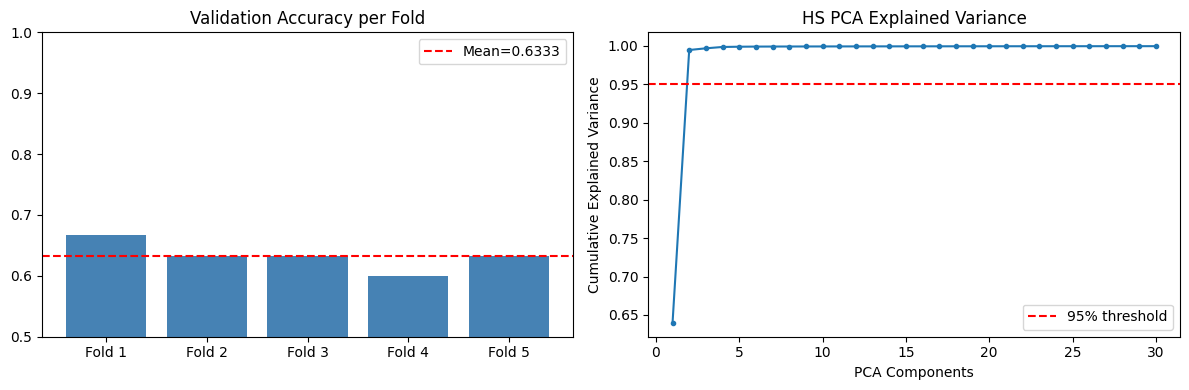


📌 Summary
  PCA components   : 30 (explains 100.0%)
  CV accuracy mean : 0.6333
  OOF accuracy     : 0.6333


In [ ]:
# ─── 14. QUICK DIAGNOSTICS ───────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Fold accuracy bar chart
axes[0].bar([f'Fold {i+1}' for i in range(N_FOLDS)], fold_val_accs, color='steelblue')
axes[0].axhline(np.mean(fold_val_accs), color='red', linestyle='--',
                label=f'Mean={np.mean(fold_val_accs):.4f}')
axes[0].set_ylim(0.5, 1.0)
axes[0].set_title('Validation Accuracy per Fold')
axes[0].legend()

# PCA explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, PCA_COMPS+1), cumvar, marker='o', markersize=3)
axes[1].axhline(0.95, color='red', linestyle='--', label='95% threshold')
axes[1].set_xlabel('PCA Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('HS PCA Explained Variance')
axes[1].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/diagnostics.png', dpi=120, bbox_inches='tight')
plt.show()

print('\n📌 Summary')
print(f'  PCA components   : {PCA_COMPS} (explains {pca.explained_variance_ratio_.sum():.1%})')
print(f'  CV accuracy mean : {np.mean(fold_val_accs):.4f}')
print(f'  OOF accuracy     : {accuracy_score(labels, oof_probs.argmax(1)):.4f}')